# Atis dataset, sql format, query based split, data analysis

Yao Fu. University of Edinburgh<br>
yao.fu@ed.ac.uk<br>
Apr 15th 2021

In [4]:
import json
import sys

sys.path.append('..')

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

from data_utils.text2sql_utils import print_sql_as_tree, sql_width_depth, simplify_sql
from tqdm import tqdm
from pprint import pprint
from collections import Counter, defaultdict

In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
data_path = '/Users/yaofu/Projects/semantic_parsing_datasets/text2sql-data/data'

## Function definition

In [8]:
data = json.load(open(data_path + '/atis.json'))

In [9]:
def test_contain_all_var(sent, varibles):
    all_in = True
    for v in varibles:
        if(v not in sent): all_in = False
    return all_in

def test_contain_all_var_w_sql(sent, sql, varibles):
    all_in = True
    for v in varibles:
        if(v not in sent): all_in = False
        if(v not in sql): all_in = False
    return all_in

## Caveat: change MIN MAX. Process this part
def preprocess(sql_data):
    sql_data_ = []
    for s in sql_data:
        if('MIN' in s or 'MAX' in s or 'COUNT' in s): 
            s_ = s.replace('MIN(', 'MIN (').replace('MAX(', 'MAX (')\
                .replace('COUNT(', 'COUNT (').replace('IS NOT NULL', 'IS-NOT-NULL')
            sql_data_.append(s_)
        else:
            sql_data_.append(s)
    return sql_data_

In [27]:
train_questions = [] 
dev_questions = []
test_questions = []
for d in data:
    sql = d['sql'][0]
    q = []
    for qi in d['sentences']:
        if(test_contain_all_var_w_sql(qi['text'], sql, qi['variables'])):
            q.append(qi['text'])
    if(d['query-split'] == 'train'): train_questions.append(q)
    elif(d['query-split'] == 'dev'): dev_questions.append(q)
    else: test_questions.append(q)

train_sql = preprocess([d['sql'][0] for d in data if d['query-split'] == 'train'])
dev_sql = preprocess([d['sql'][0] for d in data if d['query-split'] == 'dev'])
test_sql = preprocess([d['sql'][0] for d in data if d['query-split'] == 'test'])

print(len(train_questions), len(dev_questions), len(test_questions))
print(len(train_sql), len(dev_sql), len(test_sql))

828 37 82
828 37 82


In [26]:
train_questions[0]

['list all the flights that arrive at airport_code0 from various cities',
 'what flights from any city land at airport_code0',
 'show me the flights into airport_code0',
 'show me the flights arriving at airport_code0',
 'list all the flights that arrive at airport_code0',
 'list all the arriving flights at airport_code0',
 'what flights land at airport_code0',
 'show me the flights to airport_code0',
 'list all the landings at airport_code0',
 'show me the flights into airport_code0',
 'list all the landings at airport_code0',
 'list all flights arriving at airport_code0',
 'show me the flights arriving at airport_code0',
 'list all the flights that fly into airport_code0',
 'list all the flights that arrive at airport_code0 airport',
 'show me all flights arriving at airport_code0 from other airports',
 'show me the flights from all airports to airport_code0',
 'show me the flights arriving at airport_code0 from all other airports',
 'show me flights from all airports to airport_code

In [25]:
train_sql[0]

'SELECT DISTINCT FLIGHTalias0.FLIGHT_ID FROM AIRPORT AS AIRPORTalias0 , AIRPORT_SERVICE AS AIRPORT_SERVICEalias0 , CITY AS CITYalias0 , FLIGHT AS FLIGHTalias0 WHERE AIRPORTalias0.AIRPORT_CODE = "airport_code0" AND CITYalias0.CITY_CODE = AIRPORT_SERVICEalias0.CITY_CODE AND FLIGHTalias0.FROM_AIRPORT = AIRPORT_SERVICEalias0.AIRPORT_CODE AND FLIGHTalias0.TO_AIRPORT = AIRPORTalias0.AIRPORT_CODE ;'

## Eyeball data

Amoung all keys, the most important keys are `sentences`, `sql`, and `variables`

In [14]:
data[0].keys()

dict_keys(['comments', 'old-name', 'query-split', 'sentences', 'sql', 'variables'])

In [15]:
data[0]['sentences'][0]

{'text': 'list all the flights that arrive at airport_code0 from various cities',
 'question-split': 'train',
 'variables': {'airport_code0': 'MKE'}}

In [16]:
len(data[1]['sql'])

7

In [9]:
data[1]['sql'][0]

'SELECT DISTINCT FLIGHTalias0.FLIGHT_ID FROM AIRPORT_SERVICE AS AIRPORT_SERVICEalias0 , AIRPORT_SERVICE AS AIRPORT_SERVICEalias1 , CITY AS CITYalias0 , CITY AS CITYalias1 , DATE_DAY AS DATE_DAYalias0 , DAYS AS DAYSalias0 , FLIGHT AS FLIGHTalias0 WHERE ( CITYalias1.CITY_CODE = AIRPORT_SERVICEalias1.CITY_CODE AND CITYalias1.CITY_NAME = "city_name0" AND DATE_DAYalias0.DAY_NUMBER = day_number0 AND DATE_DAYalias0.MONTH_NUMBER = month_number0 AND DATE_DAYalias0.YEAR = year0 AND DAYSalias0.DAY_NAME = DATE_DAYalias0.DAY_NAME AND FLIGHTalias0.FLIGHT_DAYS = DAYSalias0.DAYS_CODE AND FLIGHTalias0.TO_AIRPORT = AIRPORT_SERVICEalias1.AIRPORT_CODE ) AND CITYalias0.CITY_CODE = AIRPORT_SERVICEalias0.CITY_CODE AND CITYalias0.CITY_NAME = "city_name1" AND FLIGHTalias0.FROM_AIRPORT = AIRPORT_SERVICEalias0.AIRPORT_CODE ;'

In [15]:
data[1]['sentences'][0]

{'text': 'give me the flights leaving city_name1 month_number0 day_number0 coming back to city_name0',
 'question-split': 'train',
 'variables': {'city_name0': 'BOSTON',
  'day_number0': '9',
  'month_number0': '8',
  'year0': '1991',
  'city_name1': 'DENVER'}}

In [16]:
data[1]['sentences'][1]

{'text': 'what flights from city_name1 to city_name0 on saturday',
 'question-split': 'train',
 'variables': {'city_name0': 'ORLANDO',
  'day_number0': '26',
  'month_number0': '7',
  'year0': '1991',
  'city_name1': 'TACOMA'}}

In [17]:
data[1]['sentences'][2]

{'text': 'city_name1 to city_name0 saturday',
 'question-split': 'train',
 'variables': {'city_name0': 'BOSTON',
  'day_number0': '26',
  'month_number0': '7',
  'year0': '1991',
  'city_name1': 'PITTSBURGH'}}

In [77]:
data[1]['sql'][1]

'SELECT DISTINCT FLIGHTalias0.FLIGHT_ID FROM AIRPORT_SERVICE AS AIRPORT_SERVICEalias0 , AIRPORT_SERVICE AS AIRPORT_SERVICEalias1 , AIRPORT_SERVICE AS AIRPORT_SERVICEalias2 , CITY AS CITYalias0 , CITY AS CITYalias1 , CITY AS CITYalias2 , DATE_DAY AS DATE_DAYalias0 , DAYS AS DAYSalias0 , FLIGHT AS FLIGHTalias0 WHERE ( ( CITYalias0.CITY_CODE = AIRPORT_SERVICEalias0.CITY_CODE AND CITYalias0.CITY_NAME = "city_name1" AND FLIGHTalias0.FROM_AIRPORT = AIRPORT_SERVICEalias0.AIRPORT_CODE ) AND CITYalias2.CITY_CODE = AIRPORT_SERVICEalias2.CITY_CODE AND CITYalias2.CITY_NAME = "city_name0" AND FLIGHTalias0.TO_AIRPORT = AIRPORT_SERVICEalias2.AIRPORT_CODE ) AND DATE_DAYalias0.DAY_NUMBER = day_number0 AND DATE_DAYalias0.MONTH_NUMBER = month_number0 AND DATE_DAYalias0.YEAR = year0 AND DAYSalias0.DAY_NAME = DATE_DAYalias0.DAY_NAME AND FLIGHTalias0.FLIGHT_DAYS = DAYSalias0.DAYS_CODE ;'

In [78]:
data[1]['variables']

[{'example': 'BOSTON',
  'location': 'unk',
  'name': 'city_name0',
  'type': 'city_name'},
 {'example': '9',
  'location': 'unk',
  'name': 'day_number0',
  'type': 'day_number'},
 {'example': '8',
  'location': 'unk',
  'name': 'month_number0',
  'type': 'month_number'},
 {'example': '1991', 'location': 'unk', 'name': 'year0', 'type': 'year'},
 {'example': 'DENVER',
  'location': 'unk',
  'name': 'city_name1',
  'type': 'city_name'}]

### Not all sentences contain all variables in the SQL, which is a problem of Atis along its history

In [14]:
all_ins = 0
for s in data[1]['sentences']:
    t = s['text']
    all_in = True
    for v in s['variables']:
        if(v not in t): all_in = False
    if(all_in):
        print(t)
        all_ins += 1

what are the flights from city_name1 to city_name0 on month_number0 day_number0 year0
from city_name1 to city_name0 on monday month_number0 day_number0 year0
what flights are available from city_name1 to city_name0 on month_number0 day_number0 year0
show all flights from city_name1 to city_name0 on month_number0 day_number0 year0
flight information on month_number0 day_number0 year0 from city_name1 to city_name0
what are the flights on month_number0 day_number0 year0 from city_name1 to city_name0
what are the flights from city_name1 to city_name0 on month_number0 day_number0 year0
what flights are available from city_name1 to city_name0 on month_number0 day_number0 year0
show me a list of flights from city_name1 to city_name0 for month_number0 day_number0 year0
can you tell me the flights on month_number0 day_number0 year0 from city_name1 to city_name0
please list all flights from city_name1 to city_name0 on month_number0 day_number0 year0
show me all the flights from city_name1 to cit

In [15]:
print(len(data[1]['sentences']), all_ins)

376 13


**The above shows that not all sentences contain all the variables in the parse**

###  How many sentences contain all their variables?

In [17]:
all_contain = 0
not_all_contain = 0
for d in data:
    for s in d['sentences']:
        all_in = test_contain_all_var(s['text'], s['variables'])
        if(all_in): all_contain += 1
        else: not_all_contain += 1
print('if all var in sent:', all_contain, not_all_contain, float(all_contain) / not_all_contain)

train_all_contain = 0
train_not_all_contain = 0
test_all_contain = 0
test_not_all_contain = 0
test_airport = 0
for d in data:
    for s in d['sentences']:
        all_in = test_contain_all_var_w_sql(s['text'], d['sql'][0], s['variables'])
        if(all_in): 
            if(d['query-split'] == 'train'):
                train_all_contain += 1
            else: 
                test_all_contain += 1
                if('AIRPORT'in d['sql'][0]):
                    test_airport += 1
        else: 
            if(d['query-split'] == 'train'):
                train_not_all_contain += 1
            else:
                test_not_all_contain += 1
print('if all var in sent and sql:', 
      train_all_contain, train_not_all_contain, test_all_contain, test_not_all_contain, test_airport)

if all var in sent: 3316 1964 1.6883910386965377
if all var in sent and sql: 2972 1840 325 143 273


In [18]:
print_sql_as_tree(data[1]['sql'][0])

SELECT DISTINCT
..FLIGHTalias0.FLIGHT_ID
FROM
..AIRPORT_SERVICE AS AIRPORT_SERVICEalias0
..AIRPORT_SERVICE AS AIRPORT_SERVICEalias1
..CITY AS CITYalias0
..CITY AS CITYalias1
..DATE_DAY AS DATE_DAYalias0
..DAYS AS DAYSalias0
..FLIGHT AS FLIGHTalias0
WHERE
..(
....CITYalias1.CITY_CODE = AIRPORT_SERVICEalias1.CITY_CODE
....AND
....CITYalias1.CITY_NAME = "city_name0"
....AND
....DATE_DAYalias0.DAY_NUMBER = day_number0
....AND
....DATE_DAYalias0.MONTH_NUMBER = month_number0
....AND
....DATE_DAYalias0.YEAR = year0
....AND
....DAYSalias0.DAY_NAME = DATE_DAYalias0.DAY_NAME
....AND
....FLIGHTalias0.FLIGHT_DAYS = DAYSalias0.DAYS_CODE
....AND
....FLIGHTalias0.TO_AIRPORT = AIRPORT_SERVICEalias1.AIRPORT_CODE
..)
..AND
..CITYalias0.CITY_CODE = AIRPORT_SERVICEalias0.CITY_CODE
..AND
..CITYalias0.CITY_NAME = "city_name1"
..AND
..FLIGHTalias0.FROM_AIRPORT = AIRPORT_SERVICEalias0.AIRPORT_CODE


In [7]:
print_sql_as_tree(data[1]['sql'][1])

SELECT DISTINCT
..FLIGHTalias0.FLIGHT_ID
FROM
..AIRPORT_SERVICE AS AIRPORT_SERVICEalias0
..AIRPORT_SERVICE AS AIRPORT_SERVICEalias1
..AIRPORT_SERVICE AS AIRPORT_SERVICEalias2
..CITY AS CITYalias0
..CITY AS CITYalias1
..CITY AS CITYalias2
..DATE_DAY AS DATE_DAYalias0
..DAYS AS DAYSalias0
..FLIGHT AS FLIGHTalias0
WHERE
..(
....(
......CITYalias0.CITY_CODE = AIRPORT_SERVICEalias0.CITY_CODE
......AND
......CITYalias0.CITY_NAME = "city_name1"
......AND
......FLIGHTalias0.FROM_AIRPORT = AIRPORT_SERVICEalias0.AIRPORT_CODE
....)
....AND
....CITYalias2.CITY_CODE = AIRPORT_SERVICEalias2.CITY_CODE
....AND
....CITYalias2.CITY_NAME = "city_name0"
....AND
....FLIGHTalias0.TO_AIRPORT = AIRPORT_SERVICEalias2.AIRPORT_CODE
..)
..AND
..DATE_DAYalias0.DAY_NUMBER = day_number0
..AND
..DATE_DAYalias0.MONTH_NUMBER = month_number0
..AND
..DATE_DAYalias0.YEAR = year0
..AND
..DAYSalias0.DAY_NAME = DATE_DAYalias0.DAY_NAME
..AND
..FLIGHTalias0.FLIGHT_DAYS = DAYSalias0.DAYS_CODE


## Output cases according to width and depth

and see the output files for an understanding

Depth and width is determined by number of nested select statements or statements at the same level

In [19]:
def write_data_depth_width(data, questions, setname):
    depth, width = [], []
    
    for sql in data:
        d, w = sql_width_depth(sql)
        depth.append(d)
        width.append(w)
    max_d = max(depth)
    max_w = max(width)
    
    fds_depth = [open('../../local/data_analysis_outputs/atis_outputs_sql/%s_depth_%d.txt' % (setname, (i + 1)), 'w') for i in range(max_d)]
    fds_width = [open('../../local/data_analysis_outputs/atis_outputs_sql/%s_width_%d.txt' % (setname, (i + 1)), 'w') for i in range(max_w)]
    depth, width = [], []
    for sql, q in zip(data, questions):
        d, w = sql_width_depth(sql)
        
        for qi in q:
            fds_depth[d - 1].write(qi + '\n')
        print_sql_as_tree(sql, fds_depth[d - 1])
        fds_depth[d - 1].write('----------------\n')
        depth.append(d)

        for qi in q:
            fds_width[w - 1].write(qi + '\n')
        print_sql_as_tree(sql, fds_width[w - 1])
        fds_width[w - 1].write('----------------\n')
        width.append(w)
    depth = Counter(depth)
    width = Counter(width)
    return depth, width

In [20]:
train_depth, train_width = write_data_depth_width(train_sql, train_questions, 'train')
print(train_depth, train_width)

Counter({1: 629, 2: 147, 3: 23, 4: 15, 5: 7, 6: 5, 8: 2}) Counter({1: 816, 3: 7, 2: 5})


In [22]:
dev_depth, dev_width = write_data_depth_width(dev_sql, dev_questions, 'dev')
print(dev_depth, dev_width)

Counter({1: 31, 2: 3, 3: 3}) Counter({1: 37})


In [23]:
test_depth, test_width = write_data_depth_width(test_sql, test_questions, 'test')
print(test_depth, test_width)

Counter({1: 53, 2: 17, 3: 4, 6: 4, 4: 3, 5: 1}) Counter({1: 77, 2: 4, 3: 1})


**From the complexity measure, the test complexity is actually smaller than training**

## How many sentences will a sql correspond to?

On average, an sql correspond to 5.57 sentences. 97% cases contain less than 5.57 + 31.84 sentences

In [44]:
num_sent = []
for d in data:
    num_sent.append(len(d['sentences']))
num_sent = np.array(num_sent)

In [42]:
np.mean(num_sent)

5.575501583949314

In [43]:
np.std(num_sent)

31.84272583549294

In [50]:
(num_sent < (np.mean(num_sent) + np.std(num_sent))).sum() / len(num_sent)

0.9767687434002112

# SQL analysis, get template. Note that the template here is different than the pattern discussed in paper

In [4]:
from utils import insert_variables

def get_template(data_sql, data_question, variables):
    sql = data_sql
    sql_vars = {}
    for sql_var in variables:
        sql_vars[sql_var['name']] = sql_var['example']
    text = data_question['text']
    text_vars = data_question['variables']

    tokens, tags, template, complete, case = insert_variables(sql, sql_vars, text, text_vars)
    return tokens, tags, template, complete, case

In [98]:
data_sql = data[1]['sql'][0]
data_question = data[1]['sentences'][0]
variables = data[1]['variables']

In [99]:
tokens, tags, template, complete = get_template(data_sql, data_question, variables)

In [102]:
print_sql_as_tree(data_sql)

SELECT DISTINCT
..FLIGHTalias0.FLIGHT_ID
FROM
..AIRPORT_SERVICE AS AIRPORT_SERVICEalias0
..AIRPORT_SERVICE AS AIRPORT_SERVICEalias1
..CITY AS CITYalias0
..CITY AS CITYalias1
..DATE_DAY AS DATE_DAYalias0
..DAYS AS DAYSalias0
..FLIGHT AS FLIGHTalias0
WHERE
....(
....CITYalias1.CITY_CODE = AIRPORT_SERVICEalias1.CITY_CODE
....AND
....CITYalias1.CITY_NAME = "city_name0"
....AND
....DATE_DAYalias0.DAY_NUMBER = day_number0
....AND
....DATE_DAYalias0.MONTH_NUMBER = month_number0
....AND
....DATE_DAYalias0.YEAR = year0
....AND
....DAYSalias0.DAY_NAME = DATE_DAYalias0.DAY_NAME
....AND
....FLIGHTalias0.FLIGHT_DAYS = DAYSalias0.DAYS_CODE
....AND
....FLIGHTalias0.TO_AIRPORT = AIRPORT_SERVICEalias1.AIRPORT_CODE
....)
..AND
..CITYalias0.CITY_CODE = AIRPORT_SERVICEalias0.CITY_CODE
..AND
..CITYalias0.CITY_NAME = "city_name1"
..AND
..FLIGHTalias0.FROM_AIRPORT = AIRPORT_SERVICEalias0.AIRPORT_CODE


In [101]:
print_sql_as_tree(template)

SELECT DISTINCT
..FLIGHTalias0.FLIGHT_ID
FROM
..AIRPORT_SERVICE AS AIRPORT_SERVICEalias0
..AIRPORT_SERVICE AS AIRPORT_SERVICEalias1
..CITY AS CITYalias0
..CITY AS CITYalias1
..DATE_DAY AS DATE_DAYalias0
..DAYS AS DAYSalias0
..FLIGHT AS FLIGHTalias0
WHERE
....(
....CITYalias1.CITY_CODE = AIRPORT_SERVICEalias1.CITY_CODE
....AND
....CITYalias1.CITY_NAME = " city_name0 "
....AND
....DATE_DAYalias0.DAY_NUMBER = day_number0
....AND
....DATE_DAYalias0.MONTH_NUMBER = month_number0
....AND
....DATE_DAYalias0.YEAR = 1991
....AND
....DAYSalias0.DAY_NAME = DATE_DAYalias0.DAY_NAME
....AND
....FLIGHTalias0.FLIGHT_DAYS = DAYSalias0.DAYS_CODE
....AND
....FLIGHTalias0.TO_AIRPORT = AIRPORT_SERVICEalias1.AIRPORT_CODE
....)
..AND
..CITYalias0.CITY_CODE = AIRPORT_SERVICEalias0.CITY_CODE
..AND
..CITYalias0.CITY_NAME = " city_name1 "
..AND
..FLIGHTalias0.FROM_AIRPORT = AIRPORT_SERVICEalias0.AIRPORT_CODE


## Check differences between sql and template

See outputs in the file, as well as notion

In [6]:
templates = []
completes = []
with open('atis_outputs_sql/template_vs_sql.txt', 'w') as fd:
    for d in data:
        data_sql = d['sql'][0]
        if('MIN' in data_sql or 'MAX' in data_sql or 'COUNT' in data_sql): 
            data_sql = data_sql.replace('MIN(', 'MIN (').replace('MAX(', 'MAX (').replace('COUNT(', 'COUNT (')
        variables = d['variables']
        for data_question in d['sentences']:
            tokens, tags, template, complete, case = get_template(data_sql, data_question, variables)
            if(case == '1' or case == '2'): 
                print('case %s' % case, file=fd)
                print(data_question['text'], file=fd)
                print('------', file=fd)
                print_sql_as_tree(template, fd)
                print('------', file=fd)
                print_sql_as_tree(complete, fd)
                print('------', file=fd)
                print_sql_as_tree(data_sql, fd)
                print('------------------------------', file=fd)

**Conclusion: use `data_sql` in our case**

# Simplify the conditions, remove unnecessary nested brackets

Note that <span class="mark">we only remove cases without nested SELECT</span> (629 v.s. 828)

In [11]:
train_sql_simple_and = []
train_sql_simple_and_or = []
train_sql_complex_and_or = []
not_processed = []
level_one_cnt = 0
for s in train_sql:
    d, w = sql_width_depth(s)
    if(d == 1):
        level_one_cnt += 1
        ret_code, sql_simple, cond_simple = simplify_sql(s)
        if(ret_code == 1):
            train_sql_simple_and.append((s, sql_simple))
        elif(ret_code == 2):
            train_sql_simple_and_or.append((s, sql_simple, cond_simple))
        elif(ret_code == 3):
            train_sql_complex_and_or.append((s, sql_simple, cond_simple))
        else: 
            not_processed.append((s, sql_simple, cond_simple))
print('train_sql:', len(train_sql))
print('level_one_cnt:', level_one_cnt)
print('train_sql_simple_and:', len(train_sql_simple_and))
print('train_sql_simple_and_or:', len(train_sql_simple_and_or))
print('train_sql_complex_and_or:', len(train_sql_complex_and_or))
print('not_processed:', len(not_processed))

train_sql: 828
level_one_cnt: 629
train_sql_simple_and: 529
train_sql_simple_and_or: 74
train_sql_complex_and_or: 20
not_processed: 6


## Simple cases with AND, 529 Cases in total

### Before

In [12]:
print_sql_as_tree(train_sql_simple_and[1][0])

SELECT DISTINCT
..FLIGHTalias0.FLIGHT_ID
FROM
..AIRPORT_SERVICE AS AIRPORT_SERVICEalias0
..AIRPORT_SERVICE AS AIRPORT_SERVICEalias1
..CITY AS CITYalias0
..CITY AS CITYalias1
..DATE_DAY AS DATE_DAYalias0
..DAYS AS DAYSalias0
..FLIGHT AS FLIGHTalias0
WHERE
..(
....CITYalias1.CITY_CODE = AIRPORT_SERVICEalias1.CITY_CODE
....AND
....CITYalias1.CITY_NAME = "city_name0"
....AND
....DATE_DAYalias0.DAY_NUMBER = day_number0
....AND
....DATE_DAYalias0.MONTH_NUMBER = month_number0
....AND
....DATE_DAYalias0.YEAR = year0
....AND
....DAYSalias0.DAY_NAME = DATE_DAYalias0.DAY_NAME
....AND
....FLIGHTalias0.FLIGHT_DAYS = DAYSalias0.DAYS_CODE
....AND
....FLIGHTalias0.TO_AIRPORT = AIRPORT_SERVICEalias1.AIRPORT_CODE
..)
..AND
..CITYalias0.CITY_CODE = AIRPORT_SERVICEalias0.CITY_CODE
..AND
..CITYalias0.CITY_NAME = "city_name1"
..AND
..FLIGHTalias0.FROM_AIRPORT = AIRPORT_SERVICEalias0.AIRPORT_CODE


### After

In [13]:
print_sql_as_tree(train_sql_simple_and[1][1])

SELECT DISTINCT
..FLIGHTalias0.FLIGHT_ID
FROM
..AIRPORT_SERVICE AS AIRPORT_SERVICEalias0
..AIRPORT_SERVICE AS AIRPORT_SERVICEalias1
..CITY AS CITYalias0
..CITY AS CITYalias1
..DATE_DAY AS DATE_DAYalias0
..DAYS AS DAYSalias0
..FLIGHT AS FLIGHTalias0
WHERE
..CITYalias1.CITY_CODE = AIRPORT_SERVICEalias1.CITY_CODE
..AND
..CITYalias0.CITY_CODE = AIRPORT_SERVICEalias0.CITY_CODE
..AND
..CITYalias0.CITY_NAME = "city_name1"
..AND
..CITYalias1.CITY_NAME = "city_name0"
..AND
..DATE_DAYalias0.DAY_NUMBER = day_number0
..AND
..DATE_DAYalias0.MONTH_NUMBER = month_number0
..AND
..DATE_DAYalias0.YEAR = year0
..AND
..DAYSalias0.DAY_NAME = DATE_DAYalias0.DAY_NAME
..AND
..FLIGHTalias0.FLIGHT_DAYS = DAYSalias0.DAYS_CODE
..AND
..FLIGHTalias0.FROM_AIRPORT = AIRPORT_SERVICEalias0.AIRPORT_CODE
..AND
..FLIGHTalias0.TO_AIRPORT = AIRPORT_SERVICEalias1.AIRPORT_CODE


## Simple cases with AND and OR, 74 Cases in total

### Before

In [11]:
print_sql_as_tree(train_sql_simple_and_or[0][0])

SELECT DISTINCT
..FLIGHTalias0.FLIGHT_ID
FROM
..AIRPORT_SERVICE AS AIRPORT_SERVICEalias0
..AIRPORT_SERVICE AS AIRPORT_SERVICEalias1
..CITY AS CITYalias0
..CITY AS CITYalias1
..DATE_DAY AS DATE_DAYalias0
..DATE_DAY AS DATE_DAYalias1
..DAYS AS DAYSalias0
..DAYS AS DAYSalias1
..FLIGHT AS FLIGHTalias0
WHERE
..(
....(
......(
........(
..........(
............FLIGHTalias0.ARRIVAL_TIME < FLIGHTalias0.DEPARTURE_TIME
..........)
..........AND
..........DATE_DAYalias0.DAY_NUMBER = day_number0
..........AND
..........DATE_DAYalias0.MONTH_NUMBER = month_number0
..........AND
..........DATE_DAYalias0.YEAR = year0
..........AND
..........DAYSalias0.DAY_NAME = DATE_DAYalias0.DAY_NAME
..........AND
..........FLIGHTalias0.FLIGHT_DAYS = DAYSalias0.DAYS_CODE
........)
........OR
........FLIGHTalias0.FLIGHT_DAYS = DAYSalias1.DAYS_CODE
........AND
........DAYSalias1.DAY_NAME = DATE_DAYalias1.DAY_NAME
........AND
........DATE_DAYalias1.YEAR = year0
........AND
........DATE_DAYalias1.MONTH_NUMBER = month_nu

### After

In [12]:
print_sql_as_tree(train_sql_simple_and_or[0][1])

SELECT DISTINCT
..FLIGHTalias0.FLIGHT_ID
FROM
..AIRPORT_SERVICE AS AIRPORT_SERVICEalias0
..AIRPORT_SERVICE AS AIRPORT_SERVICEalias1
..CITY AS CITYalias0
..CITY AS CITYalias1
..DATE_DAY AS DATE_DAYalias0
..DATE_DAY AS DATE_DAYalias1
..DAYS AS DAYSalias0
..DAYS AS DAYSalias1
..FLIGHT AS FLIGHTalias0
WHERE
..S1[0:OR]S2
..AND
..CITYalias0.CITY_CODE = AIRPORT_SERVICEalias0.CITY_CODE
..AND
..CITYalias0.CITY_NAME = "city_name1"
..AND
..CITYalias1.CITY_CODE = AIRPORT_SERVICEalias1.CITY_CODE
..AND
..CITYalias1.CITY_NAME = "city_name0"
..AND
..DATE_DAYalias1.DAY_NUMBER = day_number1
..AND
..DATE_DAYalias1.MONTH_NUMBER = month_number0
..AND
..DATE_DAYalias1.YEAR = year0
..AND
..DAYSalias1.DAY_NAME = DATE_DAYalias1.DAY_NAME
..AND
..FLIGHTalias0.FROM_AIRPORT = AIRPORT_SERVICEalias0.AIRPORT_CODE
..AND
..FLIGHTalias0.STOPS = stops0
..AND
..FLIGHTalias0.TO_AIRPORT = AIRPORT_SERVICEalias1.AIRPORT_CODE


### Left of OR

In [258]:
print_sql_as_tree(train_sql_simple_and_or[0][2]['or_states'][0]['or_left'])

FLIGHTalias0.ARRIVAL_TIME < FLIGHTalias0.DEPARTURE_TIME
AND
DATE_DAYalias0.DAY_NUMBER = day_number0
AND
DATE_DAYalias0.MONTH_NUMBER = month_number0
AND
DATE_DAYalias0.YEAR = year0
AND
DAYSalias0.DAY_NAME = DATE_DAYalias0.DAY_NAME
AND
FLIGHTalias0.FLIGHT_DAYS = DAYSalias0.DAYS_CODE


### Right of OR

In [237]:
print_sql_as_tree(train_sql_simple_and_or[0][2]['or_states'][0]['or_right'])

FLIGHTalias0.FLIGHT_DAYS = DAYSalias1.DAYS_CODE


## Complex cases, many nested brackets,  20 cases in total

### Before

In [273]:
print_sql_as_tree(train_sql_complex_and_or[0][0])

SELECT DISTINCT
..FLIGHTalias0.FLIGHT_ID
FROM
..AIRPORT_SERVICE AS AIRPORT_SERVICEalias0
..AIRPORT_SERVICE AS AIRPORT_SERVICEalias1
..CITY AS CITYalias0
..CITY AS CITYalias1
..DATE_DAY AS DATE_DAYalias0
..DAYS AS DAYSalias0
..FLIGHT AS FLIGHTalias0
WHERE
..(
....(
......(
........(
..........(
............(
..............FLIGHTalias0.ARRIVAL_TIME < arrival_time0
..............OR
..............FLIGHTalias0.TIME_ELAPSED >= time_elapsed0
............)
............AND
............FLIGHTalias0.DEPARTURE_TIME > FLIGHTalias0.ARRIVAL_TIME
..........)
..........AND
..........DATE_DAYalias0.DAY_NUMBER = day_number0
..........AND
..........DATE_DAYalias0.MONTH_NUMBER = month_number0
..........AND
..........DATE_DAYalias0.YEAR = year0
..........AND
..........DAYSalias0.DAY_NAME = DATE_DAYalias0.DAY_NAME
..........AND
..........FLIGHTalias0.FLIGHT_DAYS = DAYSalias0.DAYS_CODE
........)
........OR
........(
..........DATE_DAYalias0.DAY_NUMBER = day_number0
..........AND
..........DATE_DAYalias0.MONTH

### After

In [274]:
print_sql_as_tree(train_sql_complex_and_or[0][1])

SELECT DISTINCT
..FLIGHTalias0.FLIGHT_ID
FROM
..AIRPORT_SERVICE AS AIRPORT_SERVICEalias0
..AIRPORT_SERVICE AS AIRPORT_SERVICEalias1
..CITY AS CITYalias0
..CITY AS CITYalias1
..DATE_DAY AS DATE_DAYalias0
..DAYS AS DAYSalias0
..FLIGHT AS FLIGHTalias0
WHERE
..S1 [2:OR] S2
..AND
..FLIGHTalias0.ARRIVAL_TIME <= arrival_time1
..AND
..FLIGHTalias0.ARRIVAL_TIME >= arrival_time2
..AND
..CITYalias1.CITY_CODE = AIRPORT_SERVICEalias1.CITY_CODE
..AND
..CITYalias1.CITY_NAME = "city_name0"
..AND
..FLIGHTalias0.TO_AIRPORT = AIRPORT_SERVICEalias1.AIRPORT_CODE
..AND
..CITYalias0.CITY_CODE = AIRPORT_SERVICEalias0.CITY_CODE
..AND
..CITYalias0.CITY_NAME = "city_name1"
..AND
..FLIGHTalias0.FROM_AIRPORT = AIRPORT_SERVICEalias0.AIRPORT_CODE


### Left of First level OR

In [275]:
cond_simple = train_sql_complex_and_or[0][2]
print_sql_as_tree(cond_simple['or_states'][2]['or_left'])

S1 [0:OR] S2
AND
FLIGHTalias0.DEPARTURE_TIME > FLIGHTalias0.ARRIVAL_TIME
AND
DATE_DAYalias0.DAY_NUMBER = day_number0
AND
DATE_DAYalias0.MONTH_NUMBER = month_number0
AND
DATE_DAYalias0.YEAR = year0
AND
DAYSalias0.DAY_NAME = DATE_DAYalias0.DAY_NAME
AND
FLIGHTalias0.FLIGHT_DAYS = DAYSalias0.DAYS_CODE


### Right of First level OR, Note the NOT structure here

In [276]:
cond_simple = train_sql_complex_and_or[0][2]
print_sql_as_tree(cond_simple['or_states'][2]['or_right'])

(
..DATE_DAYalias0.DAY_NUMBER = day_number0
..AND
..DATE_DAYalias0.MONTH_NUMBER = month_number0
..AND
..DATE_DAYalias0.YEAR = year0
..AND
..DAYSalias0.DAY_NAME = DATE_DAYalias0.DAY_NAME
..AND
..FLIGHTalias0.FLIGHT_DAYS = DAYSalias0.DAYS_CODE
..AND
..NOT
..(
....(
......S1 [1:OR] S2
....)
....AND
....FLIGHTalias0.DEPARTURE_TIME > FLIGHTalias0.ARRIVAL_TIME
..)
)


### Second level OR

In [262]:
cond_simple = train_sql_complex_and_or[0][2]
print_sql_as_tree(cond_simple['or_states'][0]['or_left'])

FLIGHTalias0.ARRIVAL_TIME < arrival_time0


In [263]:
cond_simple = train_sql_complex_and_or[0][2]
print_sql_as_tree(cond_simple['or_states'][0]['or_right'])

FLIGHTalias0.TIME_ELAPSED >= time_elapsed0


In [265]:
cond_simple = train_sql_complex_and_or[0][2]
print_sql_as_tree(cond_simple['or_states'][1]['or_left'])

FLIGHTalias0.ARRIVAL_TIME < arrival_time0


In [266]:
cond_simple = train_sql_complex_and_or[0][2]
print_sql_as_tree(cond_simple['or_states'][1]['or_right'])

FLIGHTalias0.TIME_ELAPSED >= time_elapsed0


## TODO: deal with NOT ( Cond ) structure

# Vocabulary

In [28]:
train_vocab = []
for s in train_sql:
    train_vocab.extend(s[:-2].split())
train_vocab = Counter(train_vocab)

test_vocab = []
for s in test_sql:
    test_vocab.extend(s[:-2].split())
test_vocab = Counter(test_vocab)

train_total_words = sum([c for s, c in train_vocab.most_common()])
test_total_words = sum([c for s, c in test_vocab.most_common()])

print(len(train_vocab), len(test_vocab), train_total_words, test_total_words)

414 258 82397 8084


In [30]:
train_vocab_set = (train_vocab.keys())
test_vocab_set = set(test_vocab.keys())
# dev_vocab_set = set(dev_vocab.keys())

In [45]:
with open('../../data/text2sql/atis_train.vocab', 'w') as fd:
    for w in train_vocab_set:
        fd.write(w + '\n')

In [49]:
test_vocab_set - train_vocab_set

{'AIRPORTalias2',
 'AIRPORTalias2.AIRPORT_CODE',
 'AIRPORTalias3',
 'AIRPORTalias3.AIRPORT_CODE',
 'year1'}

In [25]:
train_vocab_cnt, train_vocab_str = [], []
for s, c in train_vocab.most_common(80):
    train_vocab_cnt.append(c)
    train_vocab_str.append(s)
train_vocab_cnt = np.array(train_vocab_cnt) / train_total_words
    
test_vocab_cnt, test_vocab_str = [], []
for s, c in test_vocab.most_common(80):
    test_vocab_cnt.append(c)
    test_vocab_str.append(s)
test_vocab_cnt = np.array(test_vocab_cnt) / test_total_words

data = {'freq': np.concatenate([train_vocab_cnt, test_vocab_cnt]), 
        'label': pd.Categorical(train_vocab_str + test_vocab_str), 
        'split': pd.Categorical(['train'] * len(train_vocab_cnt) + ['test'] * len(test_vocab_cnt))}
data = pd.DataFrame(data)

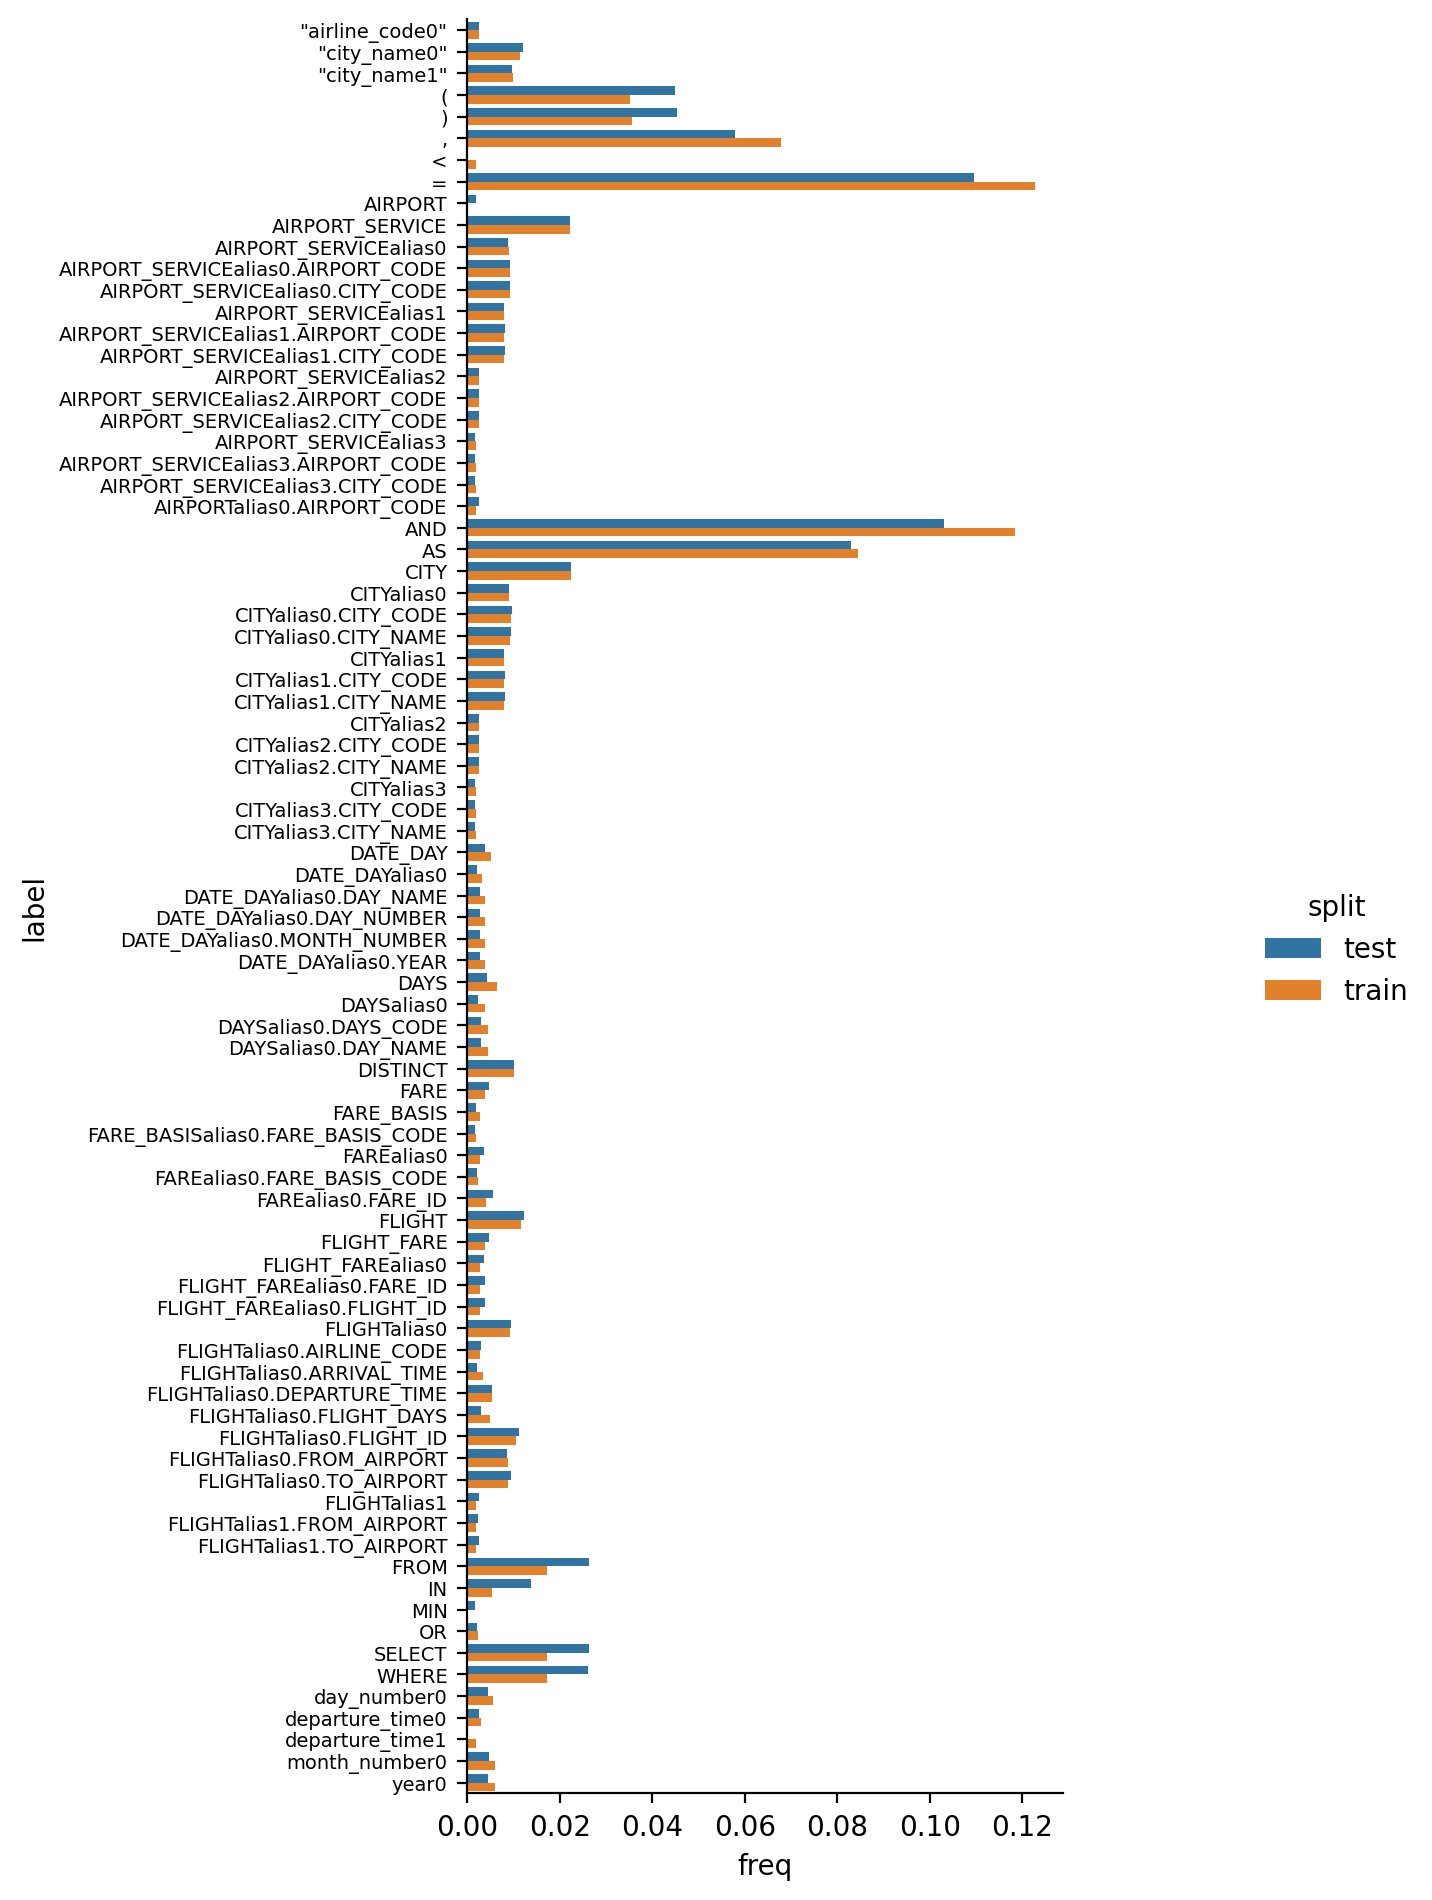

In [39]:
g = sns.catplot(data=data, kind='bar', y='label', x='freq', hue='split', orient='h')
g.set_yticklabels(size = 7)
g.fig.set_size_inches([12, 10])
g.fig.set_dpi(200)

In [40]:
train_words = set(train_vocab.keys())
test_words = set(test_vocab.keys())

In [41]:
for w in test_words - train_words:
    print(w, test_vocab[w], test_vocab[w] / test_total_words)

AIRPORTalias2 1 0.00012376237623762376
AIRPORTalias2.AIRPORT_CODE 2 0.00024752475247524753
AIRPORTalias3 1 0.00012376237623762376
AIRPORTalias3.AIRPORT_CODE 2 0.00024752475247524753
year1 1 0.00012376237623762376


**Conclusion: although there are words in test not seen in training, the difference can be ignored**